# Regularization and Evaluation of Neural Networks

In [1]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [4]:
digits = load_digits()
X = digits.data.astype('float32')
y = digits.target.astype('float32')

y_binary = y % 2

In [5]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', 
             loss='binary_crossentropy', 
             metrics=['accuracy'])

model.fit(X, y_binary, epochs=50, batch_size=360)

Epoch 1/50
5/5 [==============================] - 0s 2ms/step - loss: 1.2736 - accuracy: 0.5799
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 0.8917 - accuracy: 0.6249
Epoch 3/50
5/5 [==============================] - 0s 6ms/step - loss: 0.7643 - accuracy: 0.6700
Epoch 4/50
5/5 [==============================] - 0s 2ms/step - loss: 0.6793 - accuracy: 0.7040
Epoch 5/50
5/5 [==============================] - 0s 2ms/step - loss: 0.6190 - accuracy: 0.7229
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 0.5747 - accuracy: 0.7440
Epoch 7/50
5/5 [==============================] - 0s 2ms/step - loss: 0.5359 - accuracy: 0.7574
Epoch 8/50
5/5 [==============================] - 0s 3ms/step - loss: 0.5059 - accuracy: 0.7702
Epoch 9/50
5/5 [==============================] - 0s 3ms/step - loss: 0.4775 - accuracy: 0.7852
Epoch 10/50
5/5 [==============================] - 0s 2ms/step - loss: 0.4539 - accuracy: 0.7935
Epoch 11/50
5/5 [======================

1. `model = Sequential()`: This line creates a new neural network model using the Keras Sequential API. This API allows you to create a neural network by simply adding layers in sequence.

2. `model.add(Dense(12, activation='relu', input_dim=64))`: This line adds a new layer to the model. The layer is a dense layer, which means that each neuron in the layer is connected to every neuron in the previous layer. The layer has 12 neurons, an input dimension of 64, and uses the ReLU activation function. The input dimension represents the number of features in your data, in this case, 64.

3. `model.add(Dense(8, activation='relu'))`: This line adds another dense layer to the model with 8 neurons and the ReLU activation function. The input dimensions for this layer are automatically inferred from the previous layer.

4. `model.add(Dense(1, activation='sigmoid'))`: This line adds a final dense layer to the model with 1 neuron and the sigmoid activation function. This layer is the output layer of the network and will give us a prediction between 0 and 1.

5. `model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])`: This line compiles the model with the chosen optimizer, loss function, and metric. Here, we are using the RMSprop optimizer, binary cross-entropy as the loss function, and accuracy as the metric to evaluate the performance of the model.

6. `model.fit(X, y_binary, epochs=50, batch_size=360)`: This line trains the model using the fit() function. The training data (X) and its corresponding binary labels (y_binary) are passed as inputs. The model will be trained for 50 epochs, which means it will go through the entire dataset 50 times. The batch size is set to 360, which means the model will update its weights every 360 samples.

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling
**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [6]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [7]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, 
                    batch_size=100, verbose=1)

Epoch 1/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6909 - accuracy: 0.4961
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6905 - accuracy: 0.4978
Epoch 3/10
12/12 [==============================] - 0s 6ms/step - loss: 0.6902 - accuracy: 0.5013
Epoch 4/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.5074
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6899 - accuracy: 0.5387
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6898 - accuracy: 0.5440
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6896 - accuracy: 0.5692
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6894 - accuracy: 0.5866
Epoch 9/10
12/12 [==============================] - 0s 5ms/step - loss: 0.6893 - accuracy: 0.6005
Epoch 10/10
12/12 [==============================] - 0s 5ms/step - loss: 0.6892 - accuracy: 0.6031


In [ ]:
# we have a vanishing gradient

We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [8]:
results.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f83299a3af0>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.6908642649650574,
   0.6905080676078796,
   0.6902360916137695,
   0.6900612711906433,
   0.6899005770683289,
   0.6897608041763306,
   0.6895699501037598,
   0.6894248127937317,
   0.6892949342727661,
   0.6892145872116089],
  'accuracy': [0.4960835576057434,
   0.49782419204711914,
   0.5013054609298706,
   0.5073977112770081,
   0.5387293100357056,
   0.5439512729644775,
   0.5691906213760376,
   0.5865970253944397,
   0.6005222201347351,
   0.6031331419944763]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

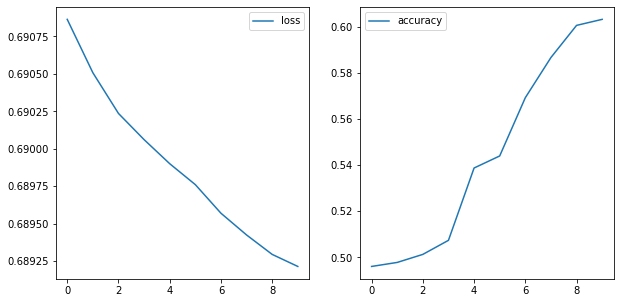

In [9]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, 
             label='accuracy')
;

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

In [10]:
X_pure_train.shape[0]

1149

In [11]:
# batch size defalut is 32
X_pure_train.shape[0] /32

35.90625

In [12]:
# relu to avoid vainishing gradient
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
results = model.fit(X_pure_train, y_pure_train, epochs=100, 
                    batch_size=None, verbose=1)

Epoch 1/100
36/36 [==============================] - 0s 7ms/step - loss: 0.6808 - accuracy: 0.6075
Epoch 2/100
36/36 [==============================] - 0s 3ms/step - loss: 0.6727 - accuracy: 0.6484
Epoch 3/100
36/36 [==============================] - 0s 3ms/step - loss: 0.6657 - accuracy: 0.6815
Epoch 4/100
36/36 [==============================] - 0s 3ms/step - loss: 0.6589 - accuracy: 0.6728
Epoch 5/100
36/36 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6867
Epoch 6/100
36/36 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.7006
Epoch 7/100
36/36 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.7032
Epoch 8/100
36/36 [==============================] - 0s 4ms/step - loss: 0.6223 - accuracy: 0.7232
Epoch 9/100
36/36 [==============================] - 0s 5ms/step - loss: 0.6100 - accuracy: 0.7328
Epoch 10/100
36/36 [==============================] - 0s 3ms/step - loss: 0.5958 - accuracy: 0.7441
Epoch 11/

36/36 [==============================] - 0s 3ms/step - loss: 0.1537 - accuracy: 0.9365
Epoch 83/100
36/36 [==============================] - 0s 2ms/step - loss: 0.1514 - accuracy: 0.9391
Epoch 84/100
36/36 [==============================] - 0s 2ms/step - loss: 0.1501 - accuracy: 0.9434
Epoch 85/100
36/36 [==============================] - 0s 2ms/step - loss: 0.1488 - accuracy: 0.9408
Epoch 86/100
36/36 [==============================] - 0s 3ms/step - loss: 0.1476 - accuracy: 0.9399
Epoch 87/100
36/36 [==============================] - 0s 2ms/step - loss: 0.1467 - accuracy: 0.9426
Epoch 88/100
36/36 [==============================] - 0s 2ms/step - loss: 0.1458 - accuracy: 0.9408
Epoch 89/100
36/36 [==============================] - 0s 2ms/step - loss: 0.1445 - accuracy: 0.9417
Epoch 90/100
36/36 [==============================] - 0s 2ms/step - loss: 0.1437 - accuracy: 0.9399
Epoch 91/100
36/36 [==============================] - 0s 2ms/step - loss: 0.1408 - accuracy: 0.9487
Epoch 92/100


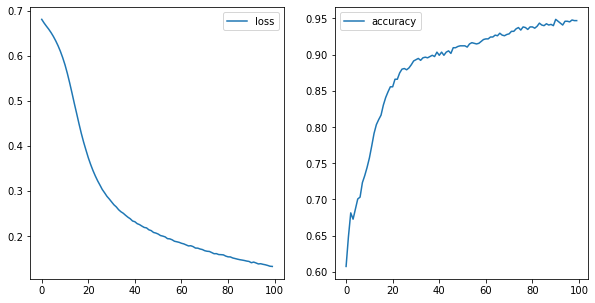

In [13]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, 
             label='accuracy');

In [ ]:
# we haven't reached diminishing result 
# bc we can still see it hasn't plateaured yet

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

Epoch 1/30
115/115 [==============================] - 0s 2ms/step - loss: 0.9756 - accuracy: 0.5030
Epoch 2/30
115/115 [==============================] - 0s 2ms/step - loss: 1.0078 - accuracy: 0.4822
Epoch 3/30
115/115 [==============================] - 0s 3ms/step - loss: 1.0082 - accuracy: 0.4935
Epoch 4/30
115/115 [==============================] - 1s 5ms/step - loss: 0.9622 - accuracy: 0.4970
Epoch 5/30
115/115 [==============================] - 0s 2ms/step - loss: 0.9583 - accuracy: 0.5126
Epoch 6/30
115/115 [==============================] - 0s 2ms/step - loss: 1.0326 - accuracy: 0.4865
Epoch 7/30
115/115 [==============================] - 0s 3ms/step - loss: 1.0117 - accuracy: 0.5039
Epoch 8/30
115/115 [==============================] - 0s 2ms/step - loss: 0.9834 - accuracy: 0.5083
Epoch 9/30
115/115 [==============================] - 0s 3ms/step - loss: 1.0021 - accuracy: 0.5057
Epoch 10/30
115/115 [==============================] - 0s 2ms/step - loss: 1.0156 - accuracy: 0.4856

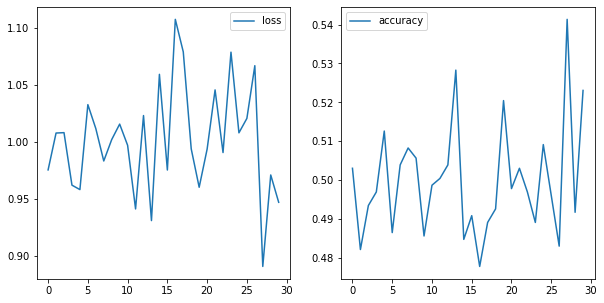

In [14]:
model = Sequential()
# we are specifiying SGD with a learning rate of 9 (9x the gradient)
sgd = SGD(lr=9)
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy');

In [ ]:
# bouncing because we are overshooting 
# too big of a learning rate

### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

Epoch 1/30
115/115 [==============================] - 1s 8ms/step - loss: 0.6643 - accuracy: 0.6388 - val_loss: 0.6202 - val_accuracy: 0.7569
Epoch 2/30
115/115 [==============================] - 0s 4ms/step - loss: 0.5212 - accuracy: 0.8172 - val_loss: 0.4409 - val_accuracy: 0.8472
Epoch 3/30
115/115 [==============================] - 0s 3ms/step - loss: 0.3556 - accuracy: 0.8721 - val_loss: 0.3067 - val_accuracy: 0.9097
Epoch 4/30
115/115 [==============================] - 0s 3ms/step - loss: 0.2664 - accuracy: 0.8947 - val_loss: 0.2652 - val_accuracy: 0.9062
Epoch 5/30
115/115 [==============================] - 0s 4ms/step - loss: 0.2160 - accuracy: 0.9164 - val_loss: 0.1990 - val_accuracy: 0.9306
Epoch 6/30
115/115 [==============================] - 0s 3ms/step - loss: 0.1842 - accuracy: 0.9286 - val_loss: 0.1768 - val_accuracy: 0.9271
Epoch 7/30
115/115 [==============================] - 0s 4ms/step - loss: 0.1601 - accuracy: 0.9347 - val_loss: 0.1566 - val_accuracy: 0.9375
Epoch 

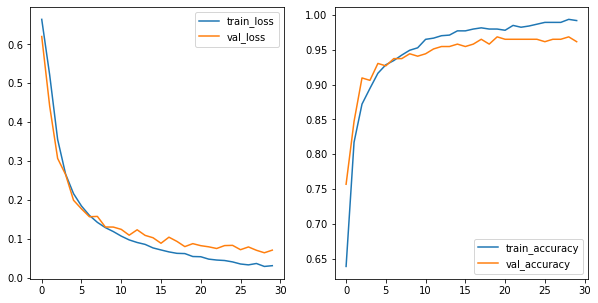

In [15]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## YOUR CODE HERE
results = model.fit(X_pure_train, y_pure_train, 
                   validation_data=(X_val, y_val),
                   epochs=30, batch_size=10, verbose=1)

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
results = model.fit(X_pure_train, y_pure_train,
                   validation_data=(X_val, y_val),
                   epochs=30, batch_size=10)
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [16]:
# Model validation accuracy at the end
results.history['val_accuracy'][-1]

0.9618055820465088

In [17]:
# gives us loss and whatever metric we gave it
model.evaluate(X_val, y_val)

9/9 [==============================] - 0s 4ms/step - loss: 0.0707 - accuracy: 0.9618


[0.07074925303459167, 0.9618055820465088]

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [18]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f830b90ca90> does not.

In [19]:
# Need to define a function to build the model
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy']
                 )
    return model

In [20]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=50,
                                          batch_size=32,
                                          verbose=1)

In [21]:
type(keras_model)

tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier

In [22]:
# going to take a while bc 50 epoch's for fist fold
# then running 50 epoch's for second fold
# then another 50 for the third
cross_val_score(keras_model, X_pure_train, y_pure_train, cv=3)

Epoch 1/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6829 - accuracy: 0.5052
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6569 - accuracy: 0.5209
Epoch 3/50
24/24 [==============================] - 0s 5ms/step - loss: 0.6092 - accuracy: 0.6266
Epoch 4/50
24/24 [==============================] - 0s 5ms/step - loss: 0.5682 - accuracy: 0.7402
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.5382 - accuracy: 0.7768
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.5130 - accuracy: 0.8003
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.4903 - accuracy: 0.8420
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.4714 - accuracy: 0.8486
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.4512 - accuracy: 0.8747
Epoch 10/50
24/24 [==============================] - 0s 3ms/step - loss: 0.4090 - accuracy: 0.8930
Epoch 11/50
24/24 [

Epoch 33/50
24/24 [==============================] - 0s 2ms/step - loss: 0.1010 - accuracy: 0.9634
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.1000 - accuracy: 0.9661
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0948 - accuracy: 0.9674
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0951 - accuracy: 0.9648
Epoch 37/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0898 - accuracy: 0.9700
Epoch 38/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0864 - accuracy: 0.9713
Epoch 39/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0831 - accuracy: 0.9700
Epoch 40/50
24/24 [==============================] - 0s 4ms/step - loss: 0.0818 - accuracy: 0.9713
Epoch 41/50
24/24 [==============================] - 0s 4ms/step - loss: 0.0820 - accuracy: 0.9752
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0811 - accuracy: 0.9726
Epoch 43/5

array([0.93994778, 0.95561355, 0.95039165])

## Regularization

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

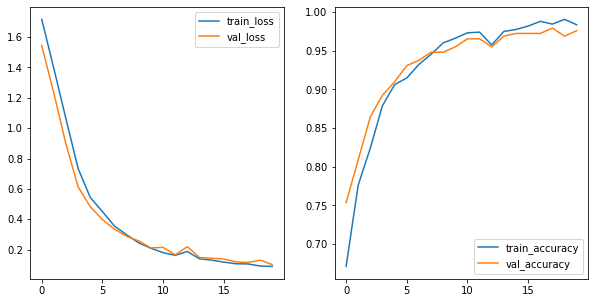

In [25]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu', kernel_regularizer=l2(l2=0.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

Adding L2 to multiple layers:

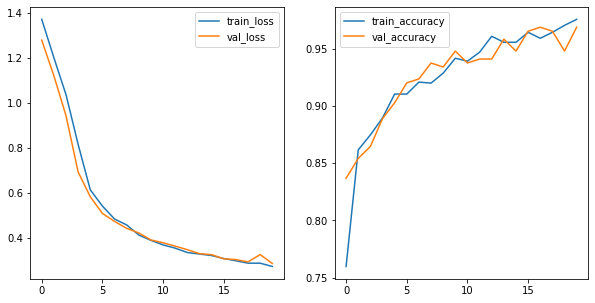

In [26]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](images/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

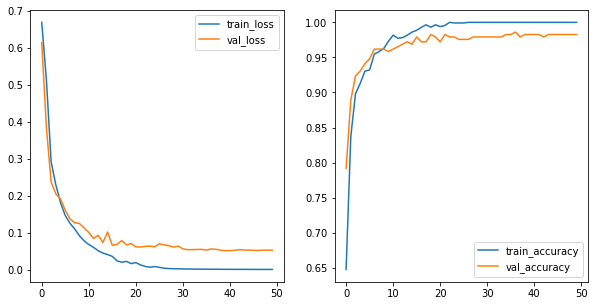

In [27]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [ ]:
results.history['val_accuracy'][-1]

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

Epoch 00008: early stopping


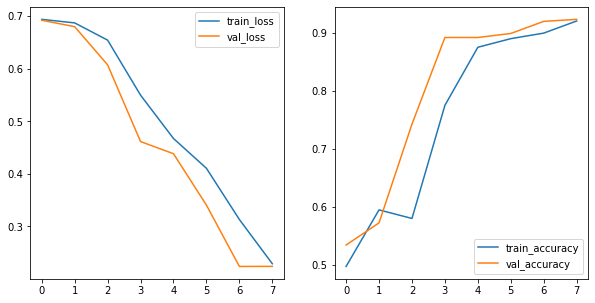

In [28]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8, 
                          verbose=1, mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

Epoch 1/100
36/36 [==============================] - 0s 12ms/step - loss: 0.6921 - accuracy: 0.5335 - val_loss: 0.6892 - val_accuracy: 0.6910
Epoch 2/100
36/36 [==============================] - 0s 4ms/step - loss: 0.6823 - accuracy: 0.6701 - val_loss: 0.6589 - val_accuracy: 0.8229
Epoch 3/100
36/36 [==============================] - 0s 4ms/step - loss: 0.6185 - accuracy: 0.7215 - val_loss: 0.5211 - val_accuracy: 0.8438
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.4654 - accuracy: 0.8146 - val_loss: 0.3396 - val_accuracy: 0.8819
Epoch 5/100
36/36 [==============================] - 0s 8ms/step - loss: 0.3608 - accuracy: 0.8581 - val_loss: 0.2842 - val_accuracy: 0.8958
Epoch 6/100
36/36 [==============================] - 0s 9ms/step - loss: 0.2995 - accuracy: 0.8886 - val_loss: 0.2488 - val_accuracy: 0.8924
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 0.2538 - accuracy: 0.9086 - val_loss: 0.2154 - val_accuracy: 0.9132
Epoch 8/100


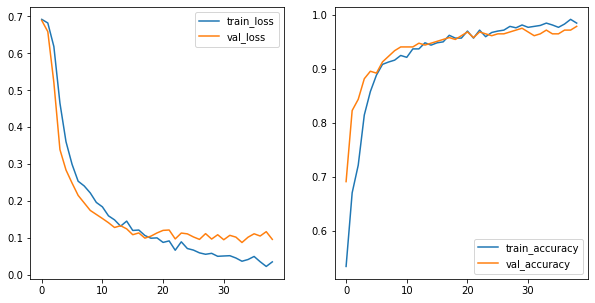

In [29]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1, patience=5,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=100, batch_size= 32,
                    verbose=1, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object



# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [30]:
results.history['val_accuracy'][-1]

0.9791666865348816

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [32]:
digits = load_digits()
X = digits.data
y = digits.target

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

In [34]:
y_pure_train.reshape(-1,1)

array([[8],
       [7],
       [4],
       ...,
       [1],
       [2],
       [8]])

For a multiclass output, our neural net expects our target to be in a certain form.

In [35]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [36]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [38]:
y_test.shape

(360, 10)

In [39]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Epoch 1/50
115/115 [==============================] - 0s 4ms/step - loss: 2.2764 - accuracy: 0.1245 - val_loss: 2.2181 - val_accuracy: 0.1840
Epoch 2/50
115/115 [==============================] - 0s 3ms/step - loss: 2.1199 - accuracy: 0.2254 - val_loss: 2.0851 - val_accuracy: 0.2153
Epoch 3/50
115/115 [==============================] - 0s 3ms/step - loss: 1.9297 - accuracy: 0.3412 - val_loss: 1.8817 - val_accuracy: 0.3681
Epoch 4/50
115/115 [==============================] - 0s 3ms/step - loss: 1.6851 - accuracy: 0.4386 - val_loss: 1.6283 - val_accuracy: 0.4375
Epoch 5/50
115/115 [==============================] - ETA: 0s - loss: 1.4538 - accuracy: 0.51 - 0s 3ms/step - loss: 1.4258 - accuracy: 0.5283 - val_loss: 1.4111 - val_accuracy: 0.5104
Epoch 6/50
115/115 [==============================] - 0s 3ms/step - loss: 1.2086 - accuracy: 0.6066 - val_loss: 1.2099 - val_accuracy: 0.5556
Epoch 7/50
115/115 [==============================] - 0s 3ms/step - loss: 1.0474 - accuracy: 0.6745 - val_

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [40]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

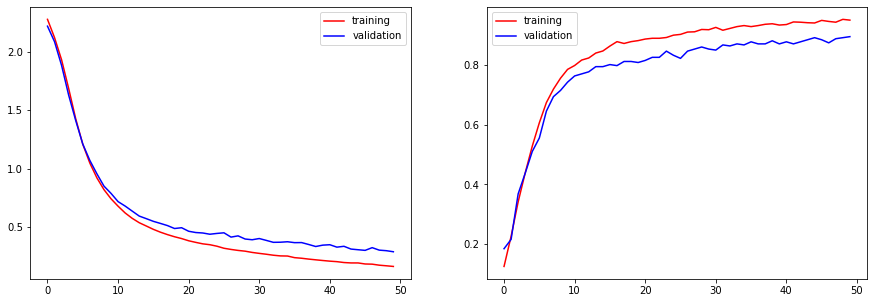

In [41]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)
ax1.legend();

In [42]:
y_hat_test = np.argmax(model.predict(X_test), axis=-1)

In [43]:
y_test_restore = ohe.inverse_transform(y_test)
confusion_matrix(y_test_restore, y_hat_test)

array([[32,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 24,  0,  0,  0,  0,  0,  0,  2,  2],
       [ 0,  0, 30,  1,  0,  0,  0,  0,  2,  0],
       [ 0,  0,  0, 33,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0, 46,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0, 46,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0, 33,  0,  0],
       [ 0,  3,  0,  0,  0,  0,  0,  0, 24,  3],
       [ 0,  0,  0,  3,  0,  1,  0,  0,  0, 36]])

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

We will explore more advanced tools in the coming days.
